## Ensemble Explorer

In this notebook we will demonstrate how to:

- compute and plot ensemble mean and spread maps
- create a stamp plot
- create a spaghetti plot
- compute and plot ensemble probability and percentile maps
- generate a CDF (Cumulative Distribution Function) plot for a given location

The data we work with in this notebook is related to the St Jude wind storm from 2013 October. The windgust and the 850 hPa geopotential forecast were retrieved from MARS in GRIB format for a few steps on a low resolution grid to provide input for the exercises. For convenience, this data is available as an earthkit-data "sample". You can find details about how this data was actually generated with earthkit-data in the "ensemble_from_mars.ipynb" notebook.

First we get the data as GRIB fieldlists.

In [1]:
import earthkit.data as ekd

ds_fc = ekd.from_source("sample", "fc_storm_st_jude.grib") # hi-res forecast
ds_en = ekd.from_source("sample", "ens_strom_st_jude.grib") # ensemble forecast

We can get an overview of what the fieldlists contain using `ls()`. Notice the ``dataType`` for the ensemble data: "cf" means control forecast, "pf" means perturbed member forecast.

In [88]:
ds_fc.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,10fg3,surface,0,20131025,0,69-72,fc,0,regular_ll
1,ecmf,10fg3,surface,0,20131025,0,75-78,fc,0,regular_ll
2,ecmf,10fg3,surface,0,20131025,0,81-84,fc,0,regular_ll
3,ecmf,z,isobaricInhPa,850,20131025,0,78,fc,0,regular_ll


In [87]:
ds_en.ls()

,centre,shortName,typeOfLevel,level,dataDate,dataTime,stepRange,dataType,number,gridType
0,ecmf,10fg3,surface,0,20131025,0,69-72,cf,0,regular_ll
1,ecmf,10fg3,surface,0,20131025,0,69-72,pf,1,regular_ll
2,ecmf,10fg3,surface,0,20131025,0,69-72,pf,2,regular_ll
3,ecmf,10fg3,surface,0,20131025,0,69-72,pf,3,regular_ll
4,ecmf,10fg3,surface,0,20131025,0,69-72,pf,4,regular_ll
...,...,...,...,...,...,...,...,...,...,...
199,ecmf,10fg3,surface,0,20131025,0,81-84,pf,46,regular_ll
200,ecmf,10fg3,surface,0,20131025,0,81-84,pf,47,regular_ll
201,ecmf,10fg3,surface,0,20131025,0,81-84,pf,48,regular_ll
202,ecmf,10fg3,surface,0,20131025,0,81-84,pf,49,regular_ll


### Compute the ensemble mean and spread

Computations on GRIB fieldlists are not yet available in earthkit-data. Therefore, we will carry out these computations in Xarray. Since the ensemble fieldlist forms a full hypercube we can convert it to Xarray using the default options. We only do it for the windgust.

In [106]:
# select windgust fields and convert them to Xarray
ds_fg = ds_en.sel(param="10fg3")
fg = ds_fg.to_xarray()

# compute ensemble mean and spread
fg_mean = fg.mean(dim="number")
fg_spread = fg.std(dim="number")

#### Create an ensemble plot

We will create a 2x2 plot for a given timestep (=78h) of the windgust forecast. The maps in the plot will show the following fields:

- deterministic forecast
- control forecast
- ensemble mean
- ensemble spread

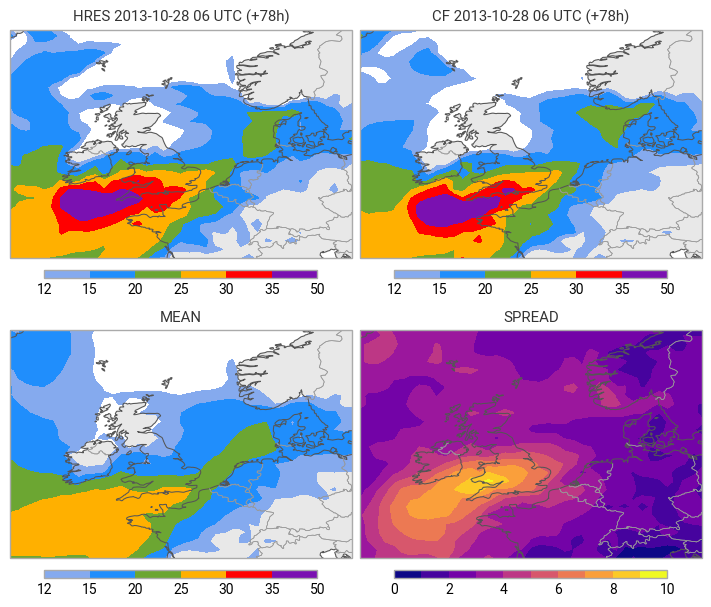

In [114]:
import earthkit.plots 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import datetime

figure = earthkit.plots.Figure(crs=ccrs.PlateCarree(), 
                               domain=[-15,15,65,45], size=(7, 6), rows=2, columns=2)

gust_style = earthkit.plots.styles.Style(
    colors=["#85AAEE", "#208EFC", "#6CA632", "#FFB000", "#FF0000", "#7A11B1"],
    levels=[12, 15, 20, 25, 30, 35, 50],
    units="m s-1",
)

# the hres forecast, GRIB
subplot = figure.add_map(0, 0)
subplot.contourf(ds_fc.sel(param="10fg3", step=78), style=gust_style)
subplot.title("HRES {time:%Y-%m-%d %H} UTC (+{lead_time}h)")
subplot.legend(label="")

# the control forecast, GRIB
subplot = figure.add_map(0, 1)
subplot.contourf(ds_fg.sel(marsType="cf", step=78), style=gust_style)
subplot.title("CF {time:%Y-%m-%d %H} UTC (+{lead_time}h)")
subplot.legend(label="")

# the ensemble mean, Xarray
subplot = figure.add_map(1, 0)
subplot.contourf(fg_mean.sel(step=datetime.timedelta(hours=78)),  style=gust_style)
subplot.title("MEAN")
subplot.legend(label="")

# the ensemble spread, Xarray
subplot = figure.add_map(1, 1)
subplot.contourf(fg_spread.sel(step=datetime.timedelta(hours=78)))
subplot.title("SPREAD")
subplot.legend(label="")

figure.land()
figure.coastlines()
figure.borders()

figure.show()

### Creating a stamp plot

In a stamp plot we plot all the ensemble members into the different map within the same plot. It provides us with a quick overview on how the forecast members differ from each other. 

A stamp plot is about managing the layout. We will create an 8x8 grid and plot the ensmeble mean, the HRES forecast and the control forecast into the first row, and the perturbed members into the rest of the cells.

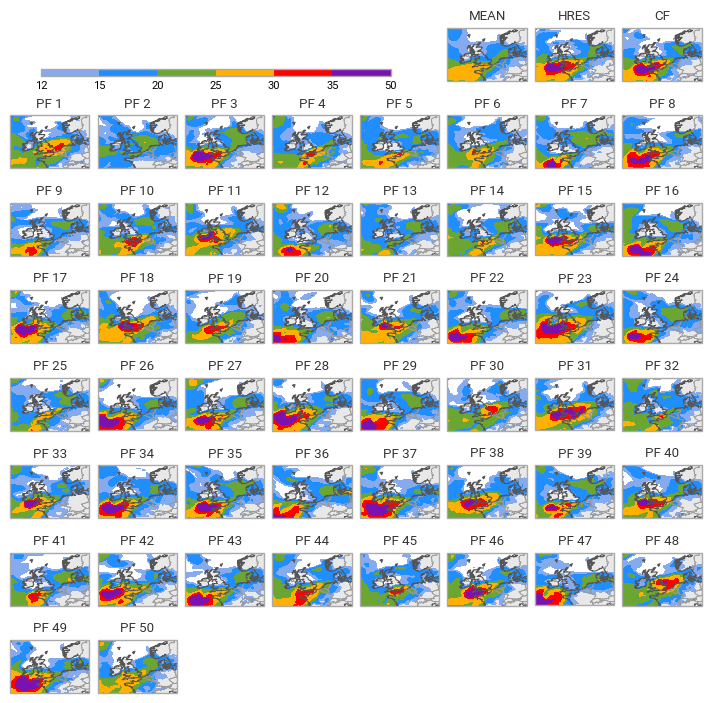

In [119]:
import earthkit.plots 
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

figure = earthkit.plots.Figure(crs=ccrs.PlateCarree(), domain=[-15,15,65,45], size=(7, 7), rows=8, columns=8)

gust_style = earthkit.plots.styles.Style(
    colors=["#85AAEE", "#208EFC", "#6CA632", "#FFB000", "#FF0000", "#7A11B1"],
    levels=[12, 15, 20, 25, 30, 35, 50],
    units="m s-1",
)

gust_style_1 = earthkit.plots.styles.Contour(
    linecolors="black",
    levels=[12, 15, 20, 25, 30, 35, 50],
    linewidths=1,
    labels=False,
    units="m s-1",
)

# enasemble mean, Xarray
subplot = figure.add_map(0, 5)
subplot.contourf(fg_mean.sel(step=datetime.timedelta(hours=78)), style=gust_style)
subplot.title("MEAN")

# HRES forecast, GRIB
subplot = figure.add_map(0, 6)
subplot.contourf(ds_fc.sel(param="10fg3", step=78), style=gust_style)
subplot.title("HRES")

# control forecast, GRIB
subplot = figure.add_map(0, 7)
subplot.contourf(ds_fg.sel(dataType="cf", step=78), style=gust_style)
subplot.title("CF")

# perturbed members, GRIB
for i, f in enumerate(ds_fg.sel(dataType="pf", step=78)):
    subplot = figure.add_map(1+i//8, i%8)
    subplot.contourf(f, style=gust_style)
    subplot.title("PF {number}")

figure.land()
figure.coastlines()
figure.borders()

ax = plt.axes((0.05, 0.9, 0.5, 0.01))
legends = figure.legend(ax=ax, label="")
legends[0].ax.tick_params(labelsize=8)

# figure.subplot_titles("{time:%Y-%m-%d %H} UTC (+{lead_time}h)")

# figure.title(
#     "ECMWF Run: {base_time:%Y-%m-%d %H} UTC (+{lead_time}h)\n{variable_name}",
#     fontsize=9, horizontalalignment="left", x=0, y=0.96,
# )

figure.show()

### Creating a spaghetti plot

In a spaghetti plot we select an isoline value and plot that isoline into the same map from all the ensemble members. We will use the 125 dam isoline of the 850 hPa geopotential forecast since it is a good indicator of the position of the trough associated with the St Jude storm.

First we filter the geopotential  data.

In [33]:
z_fc = ds_fc.sel(param="z", level=850, step=78)
z_en = ds_en.sel(param="z", level=850, step=78)

51

Then we use the same technique to build the plot contents as for the stamp plot. The title requires a special treatment: the implementation below is used to avoid having 52 titles (one for each ENS member + the deterministic forecast) in the plot.

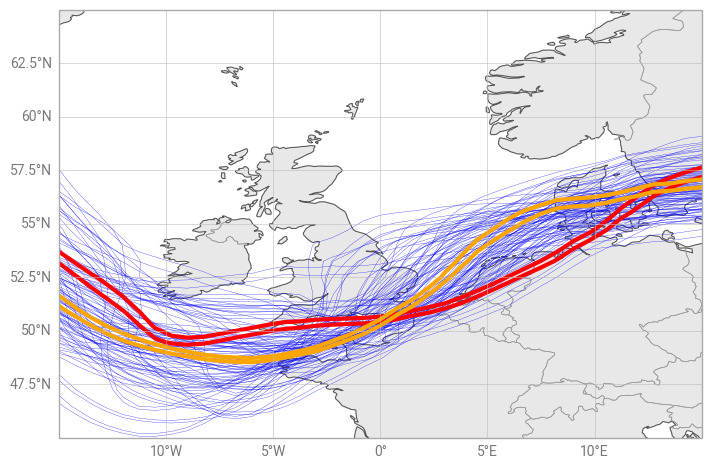

In [64]:
chart = earthkit.plots.Map(crs=ccrs.PlateCarree(), domain=[-15, 15, 65, 45], size=(7,7)) 

# perturbed members
for f in z_en.sel(dataType="pf"):
    chart.contour(f, levels=[12500,12600], linewidths=[0.2, 0.2],linecolors="blue", labels=False)

# control forecast
chart.contour(z_en.sel(dataType="cf"), levels=[12500,12600], linewidths=[3, 3],linecolors="red", labels=False)

# hres forecasts
chart.contour(z_fc, levels=[12500,12600], linewidths=[3, 3],linecolors="orange", labels=False)
    
chart.land()
chart.coastlines()
chart.borders()
chart.gridlines()

# chart.legend(label="model orography ($m$)")

chart.show()

## Generating a probability map

We could see in the stamp plot that quite a few ENS members predicted gale force wind close to the English Channel. We will now compute the probability of having a wind gust > 28 m/s (~100 km/h) for the given timestep. The computation itself is really simple. The first line below performs a masking turning all the grid point values into 0 or 1 according to the specified condition. Then the just take the mean to get the probabilities and scale the values into percentages:

In [137]:
prob = ds_fg.to_xarray() > 28
prob = prob.mean(dim="number") * 100

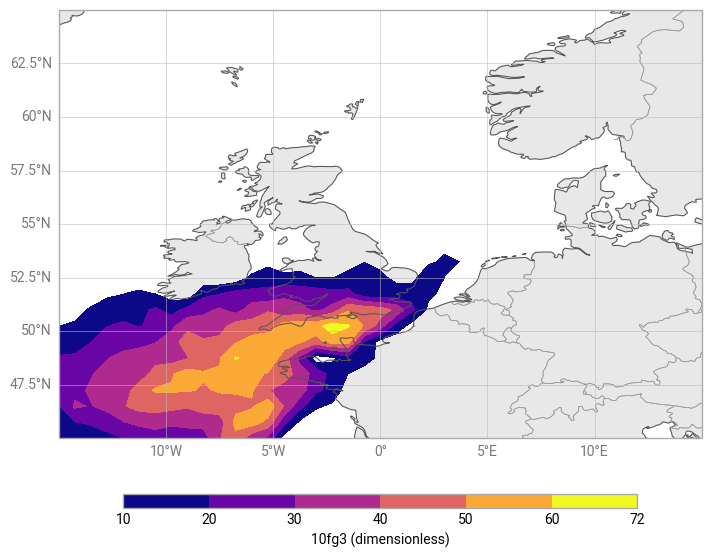

In [139]:
chart = earthkit.plots.Map(crs=ccrs.PlateCarree(), domain=[-15, 15, 65, 45], size=(7,7)) 

# chart.contourf(prob.sel(step=datetime.timedelta(hours=78)))
prob_style = earthkit.plots.styles.Style(
    # colors=["#85AAEE", "#208EFC", "#6CA632", "#FFB000", "#FF0000", "#7A11B1"],
    levels=[10,20,30,40,50,60,72],
    # units="m s-1",
)

chart.contourf(prob.sel(step=datetime.timedelta(hours=78)), style=prob_style)
chart.land()
chart.coastlines()
chart.borders()
chart.gridlines()
chart.legend()

chart.show()

### Generating a percentile map

Another way of looking at the probabilities is to use a percentile map which give us a more detailed view about the actual distribution of the ENS forecast values. In this example we will generate the percentile map for 80%. The value in each gridpoint will be the windgust value below which 80% of the ENS members fall.

In [129]:
prob = ds_fg.to_xarray()
prob = prob.quantile(0.8, dim="number")

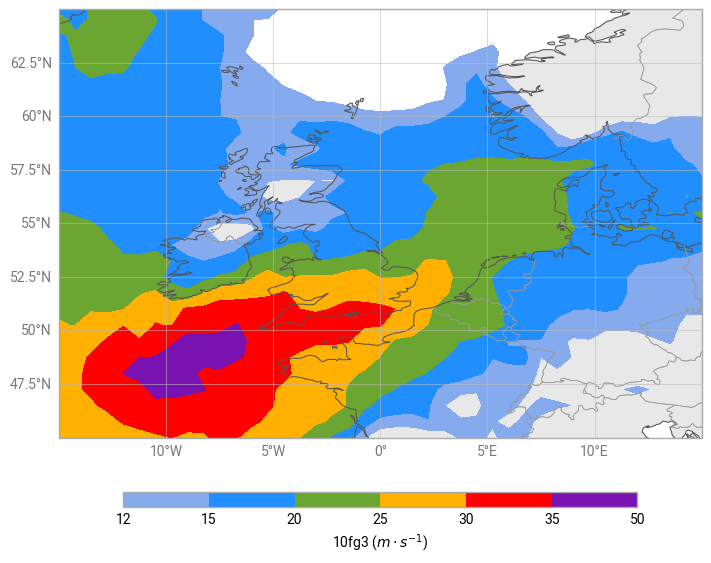

In [132]:
chart = earthkit.plots.Map(crs=ccrs.PlateCarree(), domain=[-15, 15, 65, 45], size=(7,7)) 

chart.contourf(prob.sel(step=datetime.timedelta(hours=78)), style=gust_style)

chart.land()
chart.coastlines()
chart.borders()
chart.gridlines()
chart.legend()

chart.show()